In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import confusion_matrix

# PARAMETERS
IMG_SIZE = 380
BATCH_SIZE = 16
NUM_EPOCHS_INITIAL = 10
NUM_EPOCHS_FINETUNE = 5
DATA_PATH = '/content/drive/MyDrive/DataSet'


# EfficientNetB4 works best at 380x380
IMG_SIZE = 380
BATCH_SIZE = 16 # You might need to lower this to 16 if you run out of memory (OOM)

# STEP 1: DATA PREPARATION & AUGMENTATION
# ---------------------------------------
# We'll split the data into training and validation sets using ImageDataGenerator's built-in splitting.
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print("Number of Classes:", num_classes)

Found 1756 images belonging to 3 classes.
Found 437 images belonging to 3 classes.
Number of Classes: 3


In [ ]:
# STEP 2: LOAD THE PRETRAINED MODEL & BUILD A CUSTOM HEAD
# ------------------------------------------------------
# Load EfficientNetB4
base_model = EfficientNetB4(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Build the custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Combine them
model = Model(inputs=base_model.input, outputs=predictions)

# Verify
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 380, 380,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 380, 380,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 380, 380,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 380, 380,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 381, 381,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 190, 190,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 190, 190,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 190, 190,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 190, 190,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 190, 190,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 190, 190,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 190, 190,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 190, 190,  │      1,152 │ block1a_se_excit

 Total params: 18,593,378 (70.93 MB)

 Trainable params: 18,468,171 (70.45 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [ ]:
print("Number of classes detected:", num_classes)
print("Class names found:", train_generator.class_indices)

Number of classes detected: 3
Class names found: {'ATR': 0, 'Airbus': 1, 'Boeing': 2}


In [ ]:
# STEP 3: INITIAL TRAINING
# --------------------------
# Train only the custom head; the base model.

# CALLBACKS: Learning Rate Reduction & Early Stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# COMPILE THE MODEL
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# TRAIN
history = model.fit(
    train_generator,
    epochs=NUM_EPOCHS_INITIAL,
    validation_data=validation_generator,

)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1989s 17s/step - accuracy: 0.5415 - loss: 0.8700 - val_accuracy: 0.7437 - val_loss: 0.5257
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 93s 849ms/step - accuracy: 0.8660 - loss: 0.3008 - val_accuracy: 0.8627 - val_loss: 0.3212
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 94s 850ms/step - accuracy: 0.9464 - loss: 0.1655 - val_accuracy: 0.8741 - val_loss: 0.3098
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 93s 850ms/step - accuracy: 0.9618 - loss: 0.1028 - val_accuracy: 0.8581 - val_loss: 0.3398
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 95s 861ms/step - accuracy: 0.9508 - loss: 0.1179 - val_accuracy: 0.8924 - val_loss: 0.2962
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 93s 849ms/step - accuracy: 0.9825 - loss: 0.0666 - val_accuracy: 0.8947 - val_loss: 0.3271
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 95s 860ms/step - accuracy: 0.9820 - loss: 0.0577 - val_accuracy: 0.8764 - val_loss: 0.4099
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 94s 851ms/step - accuracy: 0.9855 - loss: 0

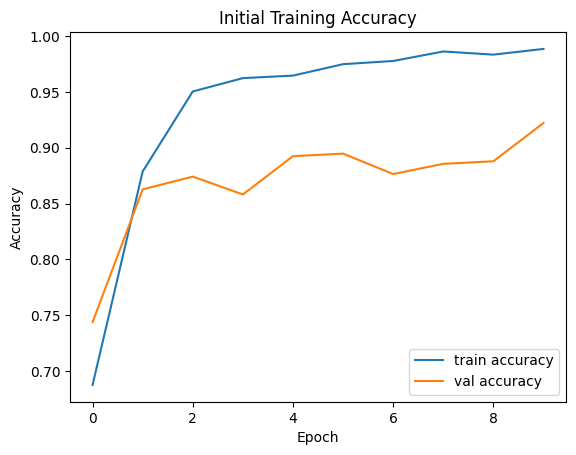

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Initial Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# STEP 5: FINE-TUNING THE MODEL
# ------------------------------------------
# Unfreeze the top few layers of the base model for fine-tuning.
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=SGD(learning_rate=1e-5, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    epochs=NUM_EPOCHS_FINETUNE,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.9848 - loss: 0.0393 - val_accuracy: 0.9176 - val_loss: 0.2631 - learning_rate: 1.0000e-05
Epoch 2/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 93s 850ms/step - accuracy: 0.9918 - loss: 0.0208 - val_accuracy: 0.9245 - val_loss: 0.2732 - learning_rate: 1.0000e-05
Epoch 3/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 94s 859ms/step - accuracy: 0.9943 - loss: 0.0208 - val_accuracy: 0.9199 - val_loss: 0.2850 - learning_rate: 1.0000e-05
Epoch 4/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 93s 844ms/step - accuracy: 0.9890 - loss: 0.0333 - val_accuracy: 0.9039 - val_loss: 0.3408 - learning_rate: 1.0000e-05
Epoch 5/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 94s 853ms/step - accuracy: 0.9948 - loss: 0.0171 - val_accuracy: 0.9268 - val_loss: 0.2604 - learning_rate: 5.0000e-06


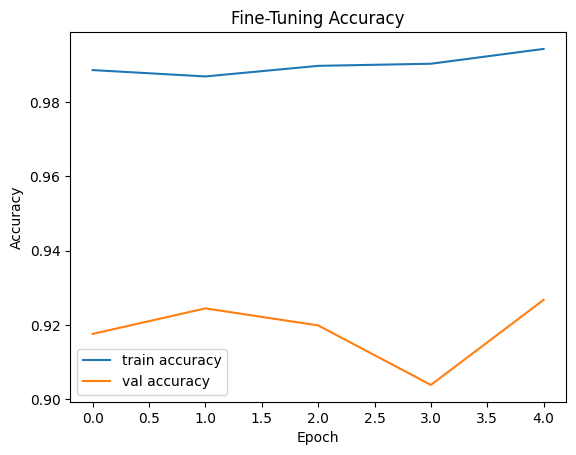

In [ ]:
# Plot fine-tuning history
plt.plot(history_finetune.history['accuracy'], label='train accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='val accuracy')
plt.title('Fine-Tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# -------------------------
# STEP 6: EVALUATE THE MODEL ON THE VALIDATION SET
# -------------------------

# Use the existing validation generator from Step 1
test_generator = validation_generator

# Print number of images and classes dynamically
num_images = test_generator.samples
num_classes = len(test_generator.class_indices)
print(f"Found {num_images} images belonging to {num_classes} classes.")

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")


Found 437 images belonging to 3 classes.
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 610ms/step - accuracy: 0.9040 - loss: 0.3439

Test Accuracy: 0.9153


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


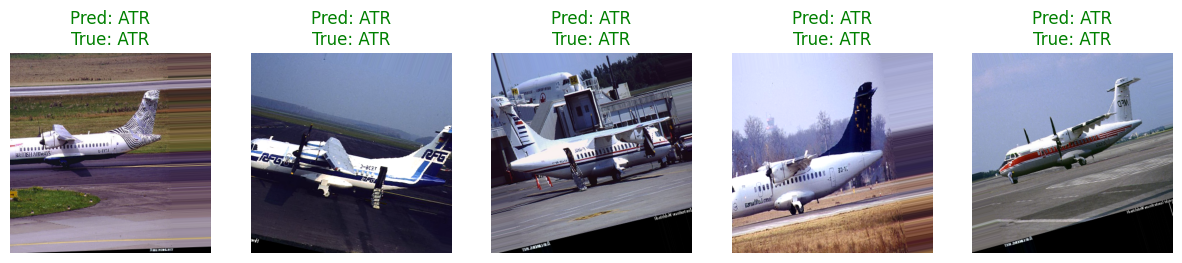

In [ ]:
# -------------------------
# STEP 7: EVALUATE THE MODEL ON THE TEST SET
# -------------------------# Get a batch of test images and labels
test_images, test_labels = next(test_generator)

# Get model predictions
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Define class names
class_names = list(test_generator.class_indices.keys())

# Display images with predictions
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    idx = random.randint(0, len(test_images) - 1)  # Pick a random image from the batch
    img = test_images[idx]

    # Rescale to 0-1 for visualization
    img_display = img.copy()
    img_display -= img_display.min()
    img_display /= img_display.max()

    ax.imshow(img_display)
    ax.axis("off")

    # Set title with prediction and true label
    pred_label = class_names[y_pred_classes[idx]]
    true_label = class_names[np.argmax(test_labels[idx])]
    ax.set_title(
        f"Pred: {pred_label}\nTrue: {true_label}",
        fontsize=12,
        color=("green" if pred_label == true_label else "red")
    )

plt.show()


In [ ]:
# Get raw probability outputs from the test generator
predictions = model.predict(test_generator)

# Convert probabilities to class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Get true class indices from the generator
true_class_indices = test_generator.classes

# Print class labels for better understanding
class_labels = list(test_generator.class_indices.keys())
print("\nClass Labels:")
for i, label in enumerate(class_labels):
    print(f"{i}: {label}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step

Class Labels:
0: ATR
1: Airbus
2: Boeing


In [ ]:
# -------------------------
# STEP 8: EVALUATE THE MODEL GET F1 SCORE
# -------------------------# Get ground truth labels
true_labels = test_generator.classes  # Actual class indices
class_labels = list(test_generator.class_indices.keys())  # Class names

# Get model predictions
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)  # Convert to class indices

# Compute classification report
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print("\nClassification Report:\n", report)

28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 616ms/step

Classification Report:
               precision    recall  f1-score   support

         ATR       1.00      0.97      0.99        40
      Airbus       0.95      0.90      0.93       240
      Boeing       0.86      0.93      0.89       157

    accuracy                           0.92       437
   macro avg       0.94      0.94      0.94       437
weighted avg       0.92      0.92      0.92       437



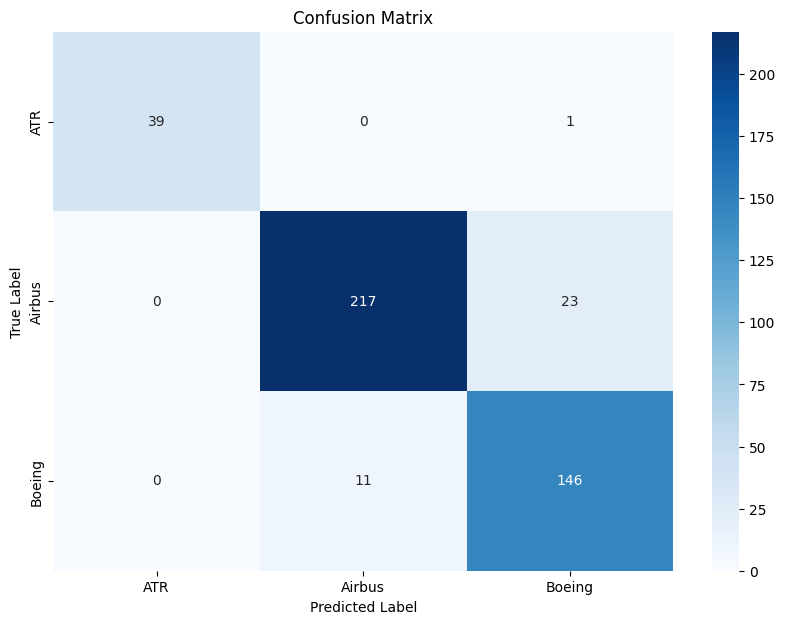

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


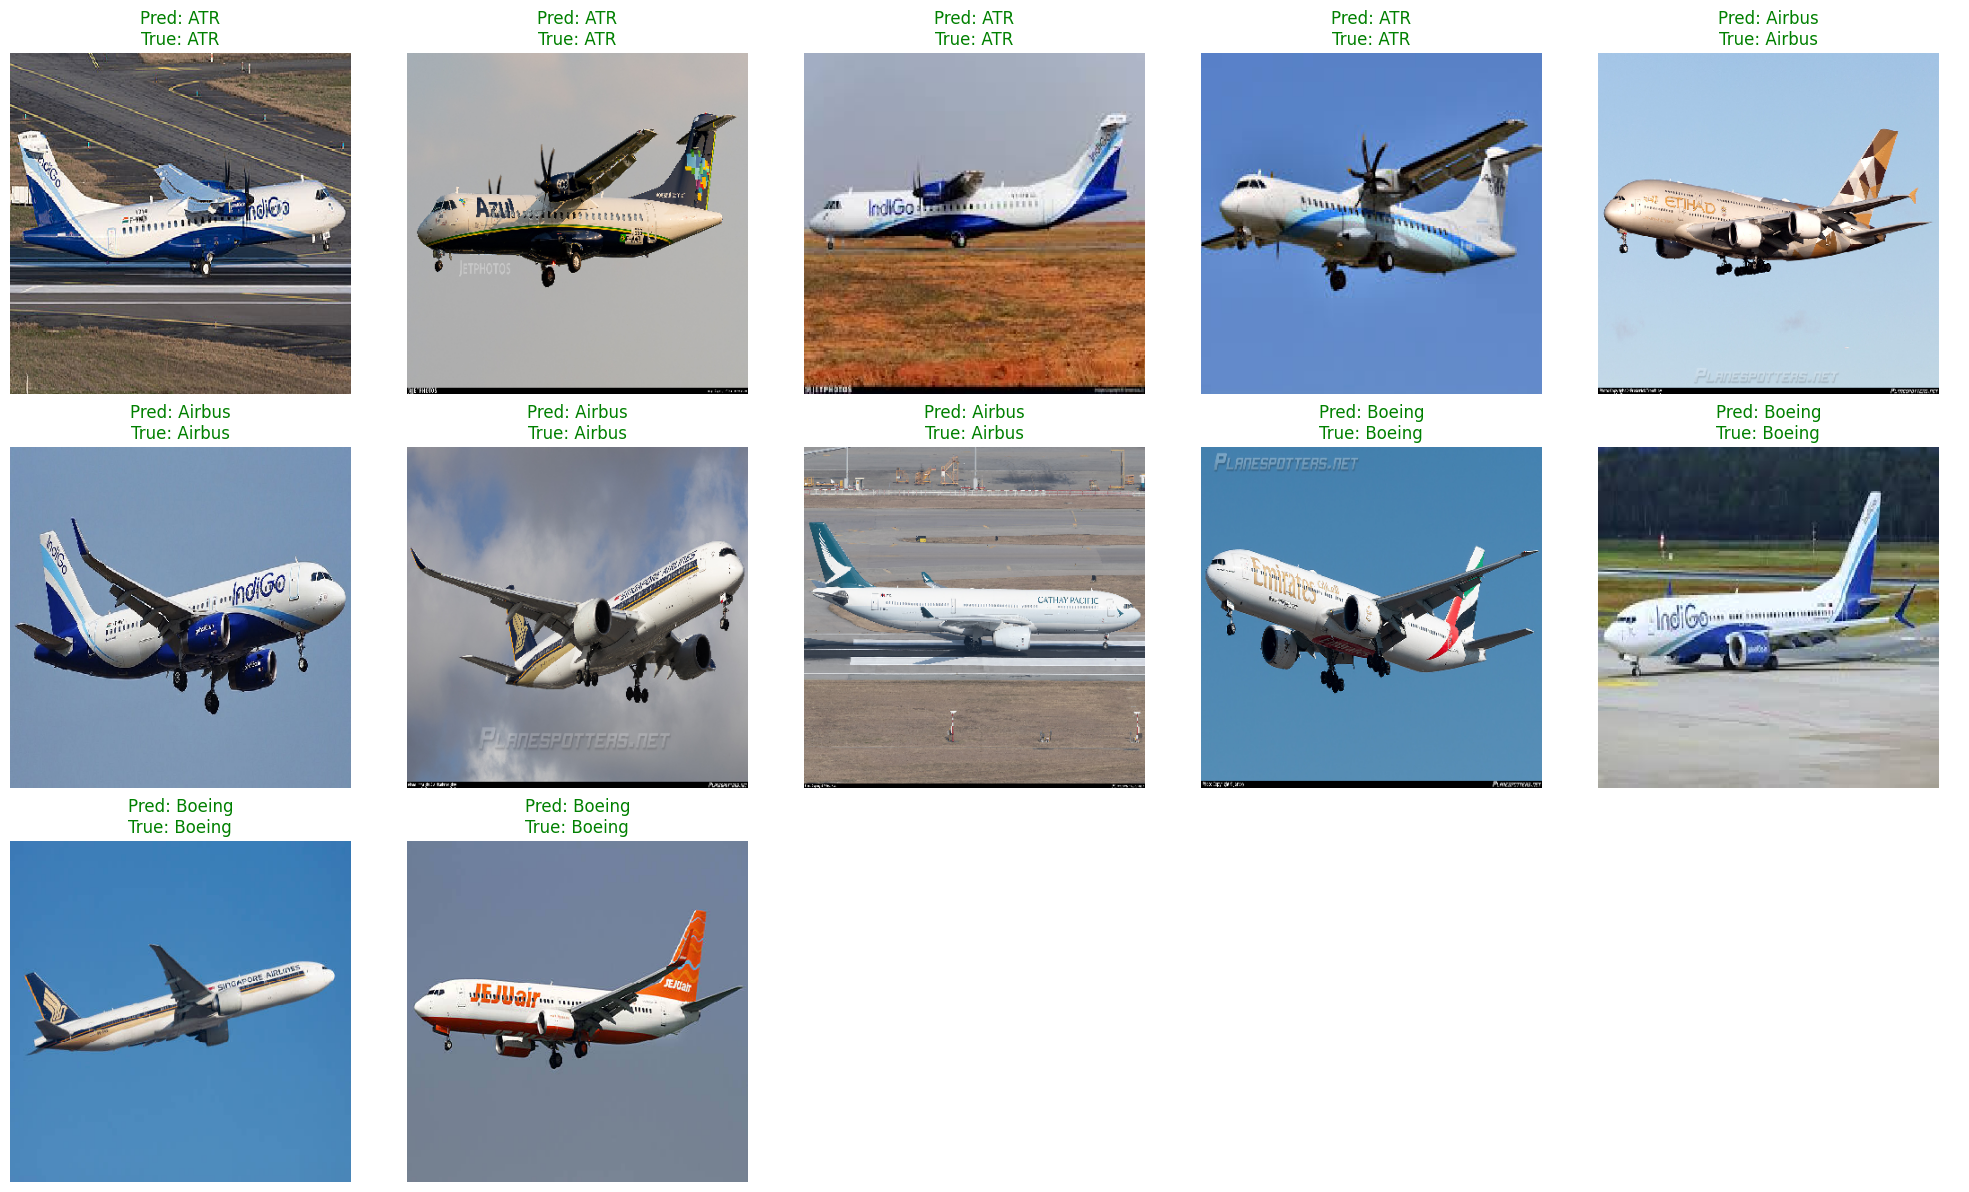

In [ ]:
# -------------------------
# STEP 9: EVALUATE THE MODEL ON TEST DATASET
# -------------------------
def preprocess_image(img_path, target_size=(380, 380)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # EfficientNet normalization
    return img_array, img

def predict_from_directory(directory_path):
    class_labels = {0: 'ATR', 1: 'Airbus', 2: 'Boeing'}

    images, preds, trues = [], [], []

    # Loop over folders
    for class_name in os.listdir(directory_path):
        class_path = os.path.join(directory_path, class_name)
        if not os.path.isdir(class_path):
            continue

        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, filename)
                img_array, img = preprocess_image(img_path)

                prediction = model.predict(img_array)
                pred_idx = np.argmax(prediction, axis=1)[0]
                pred_label = class_labels[pred_idx]

                images.append(img)
                preds.append(pred_label)
                trues.append(class_name)

    # Display images in a grid
    num_images = len(images)
    cols = 5  # Max images per row
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = np.array(axes).reshape(-1)

    for ax, img, pred, true in zip(axes, images, preds, trues):
        ax.imshow(img)
        ax.axis("off")
        color = "green" if pred == true else "red"
        ax.set_title(f"Pred: {pred}\nTrue: {true}", color=color, fontsize=12)

    # Turn off extra axes if any
    for ax in axes[num_images:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
directory_path = '/content/drive/MyDrive/test_images_2'
predict_from_directory(directory_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


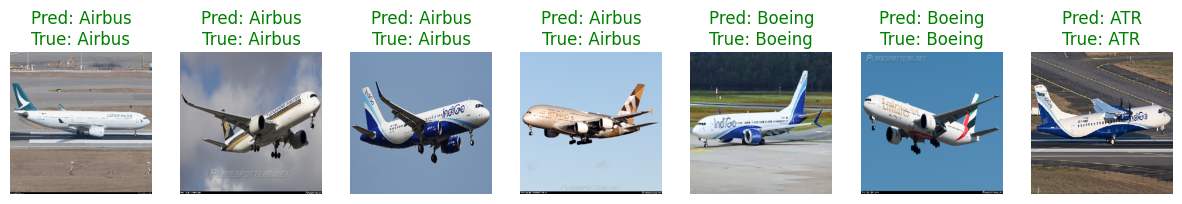

In [ ]:
# -------------------------
# STEP 9: EVALUATE THE MODEL ON TEST DATASET
# -------------------------
def preprocess_image(img_path, target_size=(380, 380)):
    img = image.load_img(img_path, target_size=target_size)  # Load image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Normalize

    return img_array, img  # Return both preprocessed and original image

def predict_from_directory(directory_path):
    class_labels = {0: 'ATR', 1: 'Airbus', 2: 'Boeing'}  # Model's class mapping

    images = []  # Store images for display
    predictions_list = []  # Store predictions
    true_labels_list = []  # Store true labels

    for class_name in os.listdir(directory_path):  # Loop over Boeing, ATR, Airbus folders
        class_path = os.path.join(directory_path, class_name)
        if not os.path.isdir(class_path):  # Skip non-directory files
            continue

        for filename in os.listdir(class_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, filename)
                img_array, original_img = preprocess_image(img_path)

                # Predict
                predictions = model.predict(img_array)
                predicted_class_idx = np.argmax(predictions, axis=1)[0]
                predicted_label = class_labels[predicted_class_idx]

                # Get the true label from folder name
                true_label = class_name

                images.append(original_img)
                predictions_list.append(predicted_label)
                true_labels_list.append(true_label)

    # Display images with predictions and true labels
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    if len(images) == 1:
        axes = [axes]  # Ensure iterable for a single image case

    for ax, img, pred_label, true_label in zip(axes, images, predictions_list, true_labels_list):
        ax.imshow(img)
        ax.axis("off")
        color = "green" if pred_label == true_label else "red"
        ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=12, color=color)

    plt.show()


directory_path = '/content/drive/MyDrive/test_images'
predict_from_directory(directory_path)